5th version - head-only trainig

In [0]:
import torch
print (torch.cuda.device_count())
print (torch.__version__)

1
1.5.0+cu101


In [0]:
import requests
from torchvision.models.inception import inception_v3
from torchvision.models.resnet import resnet50
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

In [0]:
# MOunting google drive with images
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! cp '/content/gdrive/My Drive/Colab Notebooks/images/test_params.dat.zip' ./
! cp '/content/gdrive/My Drive/Colab Notebooks/images/train_params.dat.zip' ./
! cp '/content/gdrive/My Drive/Colab Notebooks/images/filenames.dat' ./
!unzip -n test_params.dat.zip > /dev/null
!unzip -n train_params.dat.zip > /dev/null
#Uploading weights from local drive - litlle bit faster
# ! cp '/content/gdrive/My Drive/Colab Notebooks/resnet50-19c8e357.pth' ./

In [0]:
!ls -al ./

total 800712
drwxr-xr-x 1 root root      4096 May 11 09:37 .
drwxr-xr-x 1 root root      4096 May 11 09:34 ..
drwxr-xr-x 1 root root      4096 May  7 16:13 .config
-rw------- 1 root root    250000 May 11 09:37 filenames.dat
drwx------ 4 root root      4096 May 11 09:36 gdrive
drwxr-xr-x 1 root root      4096 May  4 16:26 sample_data
-rw-r--r-- 1 root root 102400000 May 11 09:24 test_params.dat
-rw------- 1 root root  92449195 May 11 09:37 test_params.dat.zip
-rw-r--r-- 1 root root 409800000 May 10 20:47 train_params.dat
-rw------- 1 root root 214994664 May 11 09:37 train_params.dat.zip


In [0]:
# SOme usefull functions
def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)



In [0]:
train_data = np.fromfile('train_params.dat', dtype=np.float64).reshape(25000, 2049)
val_data = np.fromfile('test_params.dat', dtype=np.float32).reshape(12500, 2048)

In [0]:
val_names = []
# with open('/content/gdrive/My Drive/Colab Notebooks/images/filenames.txt', 'r') as src:
#     fname = src.readline()
#     val_names.append(fname)
f = open('/content/gdrive/My Drive/Colab Notebooks/images/filenames.txt', 'r', newline='\n', )
for fname in f:
    val_names.append(fname.replace('\n', ''))

In [0]:
model = nn.Sequential()
model.add_module('fc2048', nn.Linear(in_features=2048, out_features=1024))
model.add_module('sp1', nn.Softplus())
model.add_module('fc1024', nn.Linear(in_features=1024, out_features=512))
model.add_module('sp2', nn.Softplus())
model.add_module('fc512', nn.Linear(in_features=512, out_features=256))
model.add_module('sp3', nn.Softplus())
model.add_module('fc256', nn.Linear(in_features=256, out_features=128))
model.add_module('sp4', nn.Softplus())
model.add_module('fc128', nn.Linear(in_features=128, out_features=1))
model.add_module('sigmoid', nn.Sigmoid())

In [0]:
model.train(mode=True)
model.cuda()

Sequential(
  (fc2048): Linear(in_features=2048, out_features=1024, bias=True)
  (sp1): Softplus(beta=1, threshold=20)
  (fc1024): Linear(in_features=1024, out_features=512, bias=True)
  (sp2): Softplus(beta=1, threshold=20)
  (fc512): Linear(in_features=512, out_features=256, bias=True)
  (sp3): Softplus(beta=1, threshold=20)
  (fc256): Linear(in_features=256, out_features=128, bias=True)
  (sp4): Softplus(beta=1, threshold=20)
  (fc128): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
opt = torch.optim.Adam(model.parameters())

In [0]:
np.random.shuffle(train_data)
train_set = train_data[:int(train_data.shape[0] * 0.8)]
test_set = train_data[int(train_data.shape[0] * 0.8):]
# No need for validation dataset - will use Kaggle submissions
#val_files = train_file_names[int(file_num*0.9):]
train_set.shape, test_set.shape

((20000, 2049), (5000, 2049))

In [0]:
def train_score(data, batch_size=50, tqdm_disable=False):
    Y = []
    Y_pred = []
    eps = 1e-15
    features = np.zeros([batch_size, 2048])
    batch_index = 0

    model.train(mode=False)

    for cur_features in data:
        y = cur_features[0]
        Y.append(int(y))

        # img = imread(os.path.join("train", fname))
        # img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
        features[batch_index] = cur_features[1:]

        if batch_index == batch_size-1:
            input_tensor = torch.as_tensor(features, dtype=torch.float32).cuda()

            Y_p = model(input_tensor)[:, 0].cpu()
            assert Y_p.dim() == 1, "did you forget to select first column with [:, 0]"
            # Y_p = 1/(1+torch.exp(-Y_p)) # Sigmoid returns big numbers - like 22 workaround
            Y_pred.append(Y_p.data.numpy())
            batch_index=0
            continue
        
        batch_index += 1

    Y_pred = np.concatenate(Y_pred)

    acc = accuracy_score(Y, np.round(Y_pred))
    log_loss = -np.mean(np.array(Y)*np.log(Y_pred+eps) + (1-np.array(Y))*np.log(1-Y_pred+eps))

    model.train(mode=True)

    return acc, log_loss

In [0]:
def small_train_score(test_data, batch_size=50):
    idx = np.random.randint(low=0, high=test_data.shape[0], size=batch_size)
    tests = test_data[idx, :]

    # print(tests.shape)
    acc, log_loss = train_score(tests, tqdm_disable=True)
    return acc, log_loss

In [0]:
def train_model(train_data, test_data, batch_size=50, n_epoch=5):
    batch_index = 0
    cur_epoch = 0

    Y = []
    features = np.zeros([batch_size, 2048])
    loss = torch.tensor(100)
    eps = 1e-15
    acc = []
    log_loss = []
    batch_acc = []
    batch_test_acc = []

    while cur_epoch < n_epoch:
        np.random.shuffle(train_data)

        print('Current epoch %d of %d\n' % (cur_epoch, n_epoch))
        cur_img = 0

        for cur_features in train_data:
            # y = fname.startswith("dog")
            Y.append(int(cur_features[0]))

            # img = imread(os.path.join("train", fname))
            # img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
            features[batch_index] = cur_features[1:]

            if batch_index == batch_size - 1:
                opt.zero_grad()
                input_tensor = torch.as_tensor(features, dtype=torch.float32).cuda()

                Y_pred = model(input_tensor)[:, 0].cpu()
                assert Y_pred.dim() == 1, "did you forget to select first column with [:, 0]"
                # Y_pred = 1/(1+torch.exp(-Y_pred)) # Sigmoid returns big numbers - like 22 workaround
                # print(Y_pred.data)
                loss = -torch.mean(torch.tensor(Y).cpu() * torch.log(Y_pred+eps) + (1-torch.tensor(Y).cpu()) * torch.log(1-Y_pred+eps))
                # print(loss)
                # t_acc = accuracy_score(Y, np.round(Y_pred.data.cpu()))
                # batch_acc.append(t_acc)
                # test_acc, _ = small_train_score(test_files)
                # batch_test_acc.append(test_acc)
                loss.backward()
                opt.step()
                opt.zero_grad()

                t_acc = accuracy_score(Y, np.round(Y_pred.data.cpu()))
                batch_acc.append(t_acc)
                test_acc, _ = small_train_score(test_data)
                batch_test_acc.append(test_acc)

                batch_index = 0
                Y = []
                continue
            batch_index += 1
            if cur_img % 2000 == 0:
                print('Pic %d Current loss: %f' % (cur_img, loss.data.numpy()))
            cur_img += 1
        
        cur_acc, cur_log_loss = train_score(test_data)
        print('Current loss: %f, current accuracy %f' % (cur_log_loss, cur_acc))
        acc.append(cur_acc)
        log_loss.append(cur_log_loss)
        cur_epoch += 1
    
    return acc, log_loss, batch_acc, batch_test_acc

In [0]:
r_a, r_ll, r_ba, r_ta = train_model(train_set, test_set, n_epoch=5)

Current epoch 0 of 5

Pic 0 Current loss: 100.000000
Pic 2000 Current loss: 0.020902
Pic 4000 Current loss: 0.028135
Pic 6000 Current loss: 0.025981
Pic 8000 Current loss: 0.018791
Pic 10000 Current loss: 0.045961
Pic 12000 Current loss: 0.032185
Pic 14000 Current loss: 0.014820
Pic 16000 Current loss: 0.030831
Pic 18000 Current loss: 0.080170
Current loss: 0.043228, current accuracy 0.984400
Current epoch 1 of 5

Pic 0 Current loss: 0.104062
Pic 2000 Current loss: 0.104015
Pic 4000 Current loss: 0.056158
Pic 6000 Current loss: 0.041965
Pic 8000 Current loss: 0.017340
Pic 10000 Current loss: 0.130270
Pic 12000 Current loss: 0.152252
Pic 14000 Current loss: 0.013047
Pic 16000 Current loss: 0.044851
Pic 18000 Current loss: 0.108349
Current loss: 0.030117, current accuracy 0.988800
Current epoch 2 of 5

Pic 0 Current loss: 0.003447
Pic 2000 Current loss: 0.014168
Pic 4000 Current loss: 0.393322
Pic 6000 Current loss: 0.014825
Pic 8000 Current loss: 0.038173
Pic 10000 Current loss: 0.00564

[0.9844, 0.9888, 0.9872, 0.988, 0.988]


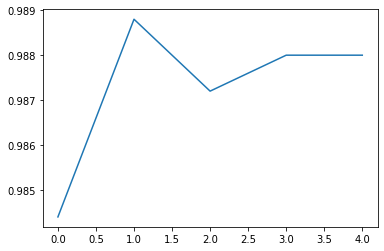

In [0]:
print(r_a)
plt.plot(r_a)

[0.0432281930822345, 0.03011728552128936, 0.04080598695490924, 0.032437270293641254, 0.03185388788412786]


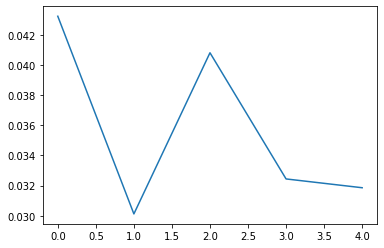

In [0]:
print(r_ll)
plt.plot(r_ll)

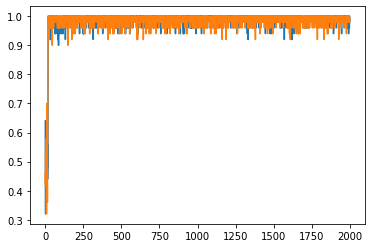

In [0]:
plt.plot(r_ba)
plt.plot(r_ta)

In [0]:
#Predicting values for submission
Y_pred = []
counter = 0
for cur_features in val_data:
    y = model(torch.as_tensor(cur_features, dtype=torch.float32).cuda())[0].cpu()
    Y_pred.append(y.data.numpy())

    if counter % 1000 == 0:
        print(counter)

    counter +=1 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Submission v5', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(val_names, Y_pred):
        dst.write('%s,%f\n' % (path, score))

In [0]:
torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/V5_head.pth')

Kaggle score 0.0691 - ranked 162